In [55]:

import torch
print(torch.cuda.is_available()) 
print(torch.cuda.get_device_name(0))  # Get GPU name


True
NVIDIA GeForce RTX 3060 Laptop GPU


In [56]:

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import cv2
import PIL
from PIL import Image
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torch.functional as F
import torch.optim as optim
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.tensorboard import SummaryWriter
from torchvision.models.segmentation import fcn_resnet50, deeplabv3_mobilenet_v3_large
import segmentation_models_pytorch as smp
import tqdm 





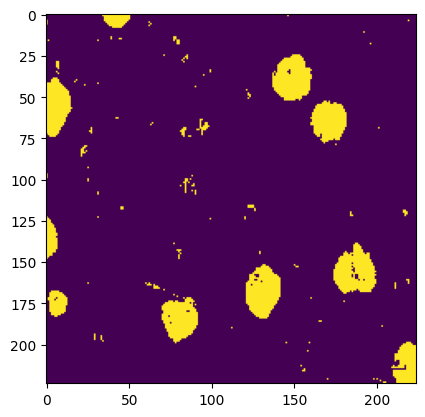

In [57]:
img = cv2.imread(r'C:\Users\Anwari Ahmed\Desktop\ALL\archive (2)\Segmented\Early\WBC-Malignant-Early-002.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # or COLOR_RGB2GRAY if already converted
binary_mask = (gray > 100).astype(np.uint8)
plt.imshow(binary_mask)

In [58]:
class AllDataset(Dataset):
  def __init__(self, img_dir, seg_dir, transform = None):
    self.image_dir = img_dir
    self.seg_dir = seg_dir
    self.transform = transform
    self.samples = []


    for label in os.listdir(img_dir):
      original_folder = os.path.join(self.image_dir, label)
      segmented_folder = os.path.join(self.seg_dir, label)

      for name in os.listdir(original_folder):
        if name.endswith(('.jpg', '.png', '.jpeg')):
          original_path = os.path.join(original_folder, name)
          segmented_path = os.path.join(segmented_folder, name)

          if os.path.exists(segmented_path):
            self.samples.append((original_path, segmented_path))

  def __len__(self):
    return len(self.samples)

  def __getitem__(self, idx):
    original_img_path, segmentation_path = self.samples[idx]

    original_image = Image.open(original_img_path).convert('RGB')
    segmented_image = Image.open(segmentation_path).convert('HSV')
    mask_np = np.array(segmented_image)
    h = mask_np[:,:,0]

    mask_binary = (h > 50).astype(np.uint8)

    if self.transform:
        augmented = self.transform(image = np.array(original_image), mask = mask_binary)
        original_image = augmented['image']
        mask = torch.tensor(augmented['mask'], dtype = torch.long)
      
        return original_image, mask

  

Image_transforms = A.Compose([ #using the augmentations library for performing transformation as it handles masks better and skips their normalisation
    A.Resize(224,224),
    A.HorizontalFlip(p = 0.5),
    A.VerticalFlip(p = 0.5),
    A.Rotate(limit = 30, p = 0.3),
    #A.RandomBrightnessContrast(p=0.2),
    #A.GaussNoise(std_range=(0.1, 0.2), p=0.15),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    A.ToTensorV2()
])


In [59]:


dataset = AllDataset(img_dir= r'C:\Users\Anwari Ahmed\Desktop\ALL\archive (2)\Original',
                      seg_dir= r'C:\Users\Anwari Ahmed\Desktop\ALL\archive (2)\Segmented', 
                      transform= Image_transforms)

#Train test split of 70, 15, 15 %.
dataset_size = len(dataset)
train_size = int(0.7 * dataset_size)

val_size = int(0.5 * (dataset_size - train_size))
test_size = dataset_size - train_size - val_size

train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

print(len(train_set))
print(len(val_set))
print(len(test_set))

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_set, batch_size= 32, shuffle = False)



2279
488
489


In [60]:
#Debug
for images, masks in train_loader: 
    print(images.shape)
    print(masks.shape)
    break

C:\Users\Anwari Ahmed\AppData\Local\Temp\ipykernel_1736\4146914188.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype = torch.long)


torch.Size([32, 3, 224, 224])
torch.Size([32, 224, 224])


In [ ]:

# Initialize TensorBoard writer
writer = SummaryWriter(log_dir='runs/segmentation_experiment11')




# class LightSegmentationModel(nn.Module):
#     def __init__(self, num_classes=2):
#         super(LightSegmentationModel, self).__init__()
#         self.model = deeplabv3_mobilenet_v3_large(weights="DEFAULT")
#         self.model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)

#     def forward(self, x):
#         return self.model(x)['out']
    


unetmodel = smp.Unet(encoder_name = 'resnet18', encoder_weights='imagenet',in_channels=3, classes = 2 )

# Usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = LightSegmentationModel(num_classes=2).to(device)
model = unetmodel.to(device)

# Loss & Optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

# Training config
num_epochs = 250
train_losses = []
val_losses = []

# Global step for TensorBoard logging
global_step = 0

for epoch in tqdm.tqdm(range(num_epochs), total = num_epochs):

    model.train()
    train_loss = 0.0

    for images, masks in train_loader:
        images = images.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)

        preds = model(images)
        loss = loss_fn(preds, masks)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # TensorBoard: log per batch
        writer.add_scalar('Loss/train_batch', loss.item(), global_step)
        global_step += 1

    # Compute average train loss
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    writer.add_scalar('Loss/train_epoch', avg_train_loss, epoch)

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {avg_train_loss:.4f}")

    # Validation
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)

            preds = model(images)
            loss = loss_fn(preds, masks)
            test_loss += loss.item()

    avg_val_loss = test_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    writer.add_scalar('Loss/val_epoch', avg_val_loss, epoch)

    print(f"Val Loss: {avg_val_loss:.4f}")
    print('-' * 30)

# Save model
torch.save(model.state_dict(), 'model.pth')

# Close TensorBoard writer
writer.close()

# Plot loss curves
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='x')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()


  0%|          | 0/250 [00:00<?, ?it/s]C:\Users\Anwari Ahmed\AppData\Local\Temp\ipykernel_1736\4146914188.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype = torch.long)


Epoch [1/250]
Train Loss: 0.4656


  0%|          | 1/250 [00:36<2:32:50, 36.83s/it]

Val Loss: 0.3751
------------------------------
Epoch [2/250]
Train Loss: 0.3589


  1%|          | 2/250 [01:12<2:30:08, 36.32s/it]

Val Loss: 0.3494
------------------------------
Epoch [3/250]
Train Loss: 0.3407


  1%|          | 3/250 [01:47<2:27:05, 35.73s/it]

Val Loss: 0.3307
------------------------------
Epoch [4/250]
Train Loss: 0.3323


  2%|▏         | 4/250 [02:21<2:23:17, 34.95s/it]

Val Loss: 0.3258
------------------------------
Epoch [5/250]
Train Loss: 0.3274


  2%|▏         | 5/250 [02:55<2:21:10, 34.57s/it]

Val Loss: 0.3215
------------------------------
Epoch [6/250]
Train Loss: 0.3213


  2%|▏         | 6/250 [03:29<2:19:45, 34.37s/it]

Val Loss: 0.3212
------------------------------
Epoch [7/250]
Train Loss: 0.3183


  3%|▎         | 7/250 [04:05<2:21:02, 34.82s/it]

Val Loss: 0.3132
------------------------------
Epoch [8/250]
Train Loss: 0.3169


  3%|▎         | 8/250 [04:38<2:18:47, 34.41s/it]

Val Loss: 0.3164
------------------------------
Epoch [9/250]
Train Loss: 0.3111


  4%|▎         | 9/250 [05:10<2:15:13, 33.67s/it]

Val Loss: 0.3073
------------------------------
Epoch [10/250]
Train Loss: 0.3062


  4%|▍         | 10/250 [05:41<2:10:38, 32.66s/it]

Val Loss: 0.3015
------------------------------
Epoch [11/250]
Train Loss: 0.3033


  4%|▍         | 11/250 [06:11<2:07:31, 32.01s/it]

Val Loss: 0.2995
------------------------------
Epoch [12/250]
Train Loss: 0.2987


  5%|▍         | 12/250 [06:42<2:05:42, 31.69s/it]

Val Loss: 0.2991
------------------------------
Epoch [13/250]
Train Loss: 0.2961


  5%|▌         | 13/250 [07:13<2:04:08, 31.43s/it]

Val Loss: 0.2942
------------------------------
Epoch [14/250]
Train Loss: 0.2940


  6%|▌         | 14/250 [07:43<2:02:22, 31.11s/it]

Val Loss: 0.2964
------------------------------
Epoch [15/250]
Train Loss: 0.2932


  6%|▌         | 15/250 [08:14<2:01:13, 30.95s/it]

Val Loss: 0.2962
------------------------------
Epoch [16/250]
Train Loss: 0.2905


  6%|▋         | 16/250 [08:45<2:00:44, 30.96s/it]

Val Loss: 0.2913
------------------------------
Epoch [17/250]
Train Loss: 0.2882


  7%|▋         | 17/250 [09:16<1:59:47, 30.85s/it]

Val Loss: 0.2936
------------------------------
Epoch [18/250]
Train Loss: 0.2892


  7%|▋         | 18/250 [09:45<1:58:10, 30.56s/it]

Val Loss: 0.2903
------------------------------
Epoch [19/250]
Train Loss: 0.2869


  8%|▊         | 19/250 [10:15<1:57:01, 30.40s/it]

Val Loss: 0.2900
------------------------------
Epoch [20/250]
Train Loss: 0.2853


  8%|▊         | 20/250 [10:45<1:55:49, 30.21s/it]

Val Loss: 0.2892
------------------------------
Epoch [21/250]
Train Loss: 0.2855


  8%|▊         | 21/250 [11:15<1:54:56, 30.12s/it]

Val Loss: 0.2943
------------------------------
Epoch [22/250]
Train Loss: 0.2833


  9%|▉         | 22/250 [11:45<1:54:02, 30.01s/it]

Val Loss: 0.2848
------------------------------
Epoch [23/250]
Train Loss: 0.2826


  9%|▉         | 23/250 [12:15<1:53:31, 30.01s/it]

Val Loss: 0.2849
------------------------------
Epoch [24/250]
Train Loss: 0.2800


 10%|▉         | 24/250 [12:45<1:52:46, 29.94s/it]

Val Loss: 0.2815
------------------------------
Epoch [25/250]
Train Loss: 0.2803


 10%|█         | 25/250 [13:15<1:52:18, 29.95s/it]

Val Loss: 0.2890
------------------------------
Epoch [26/250]
Train Loss: 0.2793


 10%|█         | 26/250 [13:44<1:51:36, 29.89s/it]

Val Loss: 0.2833
------------------------------
Epoch [27/250]
Train Loss: 0.2797


 11%|█         | 27/250 [14:15<1:51:25, 29.98s/it]

Val Loss: 0.2811
------------------------------
Epoch [28/250]
Train Loss: 0.2782


 11%|█         | 28/250 [14:45<1:51:28, 30.13s/it]

Val Loss: 0.2867
------------------------------
Epoch [29/250]
Train Loss: 0.2793


 12%|█▏        | 29/250 [15:15<1:50:47, 30.08s/it]

Val Loss: 0.2820
------------------------------
Epoch [30/250]
Train Loss: 0.2799


 12%|█▏        | 30/250 [15:45<1:50:17, 30.08s/it]

Val Loss: 0.2826
------------------------------
Epoch [31/250]
Train Loss: 0.2803


 12%|█▏        | 31/250 [16:15<1:49:38, 30.04s/it]

Val Loss: 0.2817
------------------------------
Epoch [32/250]
Train Loss: 0.2770


 13%|█▎        | 32/250 [16:45<1:48:53, 29.97s/it]

Val Loss: 0.2809
------------------------------
Epoch [33/250]
Train Loss: 0.2757


 13%|█▎        | 33/250 [17:17<1:51:12, 30.75s/it]

Val Loss: 0.2805
------------------------------
Epoch [34/250]
Train Loss: 0.2750


 14%|█▎        | 34/250 [17:49<1:51:20, 30.93s/it]

Val Loss: 0.2812
------------------------------
Epoch [35/250]
Train Loss: 0.2729


 14%|█▍        | 35/250 [18:19<1:49:45, 30.63s/it]

Val Loss: 0.2805
------------------------------
Epoch [36/250]
Train Loss: 0.2772


 14%|█▍        | 36/250 [18:49<1:48:34, 30.44s/it]

Val Loss: 0.2877
------------------------------
Epoch [37/250]
Train Loss: 0.2774


 15%|█▍        | 37/250 [19:19<1:47:29, 30.28s/it]

Val Loss: 0.2813
------------------------------
Epoch [38/250]
Train Loss: 0.2733


 15%|█▌        | 38/250 [19:49<1:46:57, 30.27s/it]

Val Loss: 0.2841
------------------------------
Epoch [39/250]
Train Loss: 0.2719


 16%|█▌        | 39/250 [20:20<1:46:51, 30.39s/it]

Val Loss: 0.2834
------------------------------
Epoch [40/250]
Train Loss: 0.2722


 16%|█▌        | 40/250 [20:49<1:45:45, 30.22s/it]

Val Loss: 0.2804
------------------------------
Epoch [41/250]
Train Loss: 0.2705


 16%|█▋        | 41/250 [21:19<1:44:53, 30.11s/it]

Val Loss: 0.2795
------------------------------
Epoch [42/250]
Train Loss: 0.2681


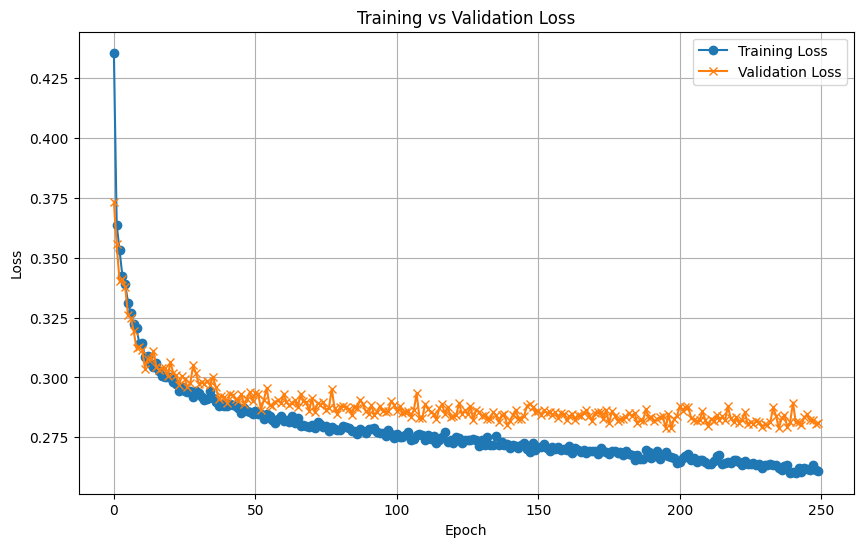

In [ ]:
# Plot loss curves
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='x')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
model.state_dict(r'C:\Users\Anwari Ahmed\Desktop\ALL\model.pth')



print(model.state_dict)

C:\Users\Anwari Ahmed\AppData\Local\Temp\ipykernel_1736\1747429440.py:1: FutureWarning: Positional args are being deprecated, use kwargs instead. Refer to https://pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  model.state_dict(r'C:\Users\Anwari Ahmed\Desktop\ALL\model.pth')


TypeError: 'str' object does not support item assignment